## Пример использования sklearn интерфейса поверх конвейера bosk

Scikit-learn — это стандартный инструмент, который использует каждый специалист по обработке данных, поэтому, вероятно, Вы бы хотели иметь адаптер между конвейером `bosk` и моделью scikit-learn. Мы разработали такие классы для моделей классификации и регрессии. 

Давайте сделаем классификационную `bosk` модель.

In [1]:
from bosk.executor.sklearn_interface import BoskPipelineClassifier
from bosk.painter.graphviz import GraphvizPainter
from bosk.pipeline.builder.functional import FunctionalPipelineBuilder
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from IPython.display import Image

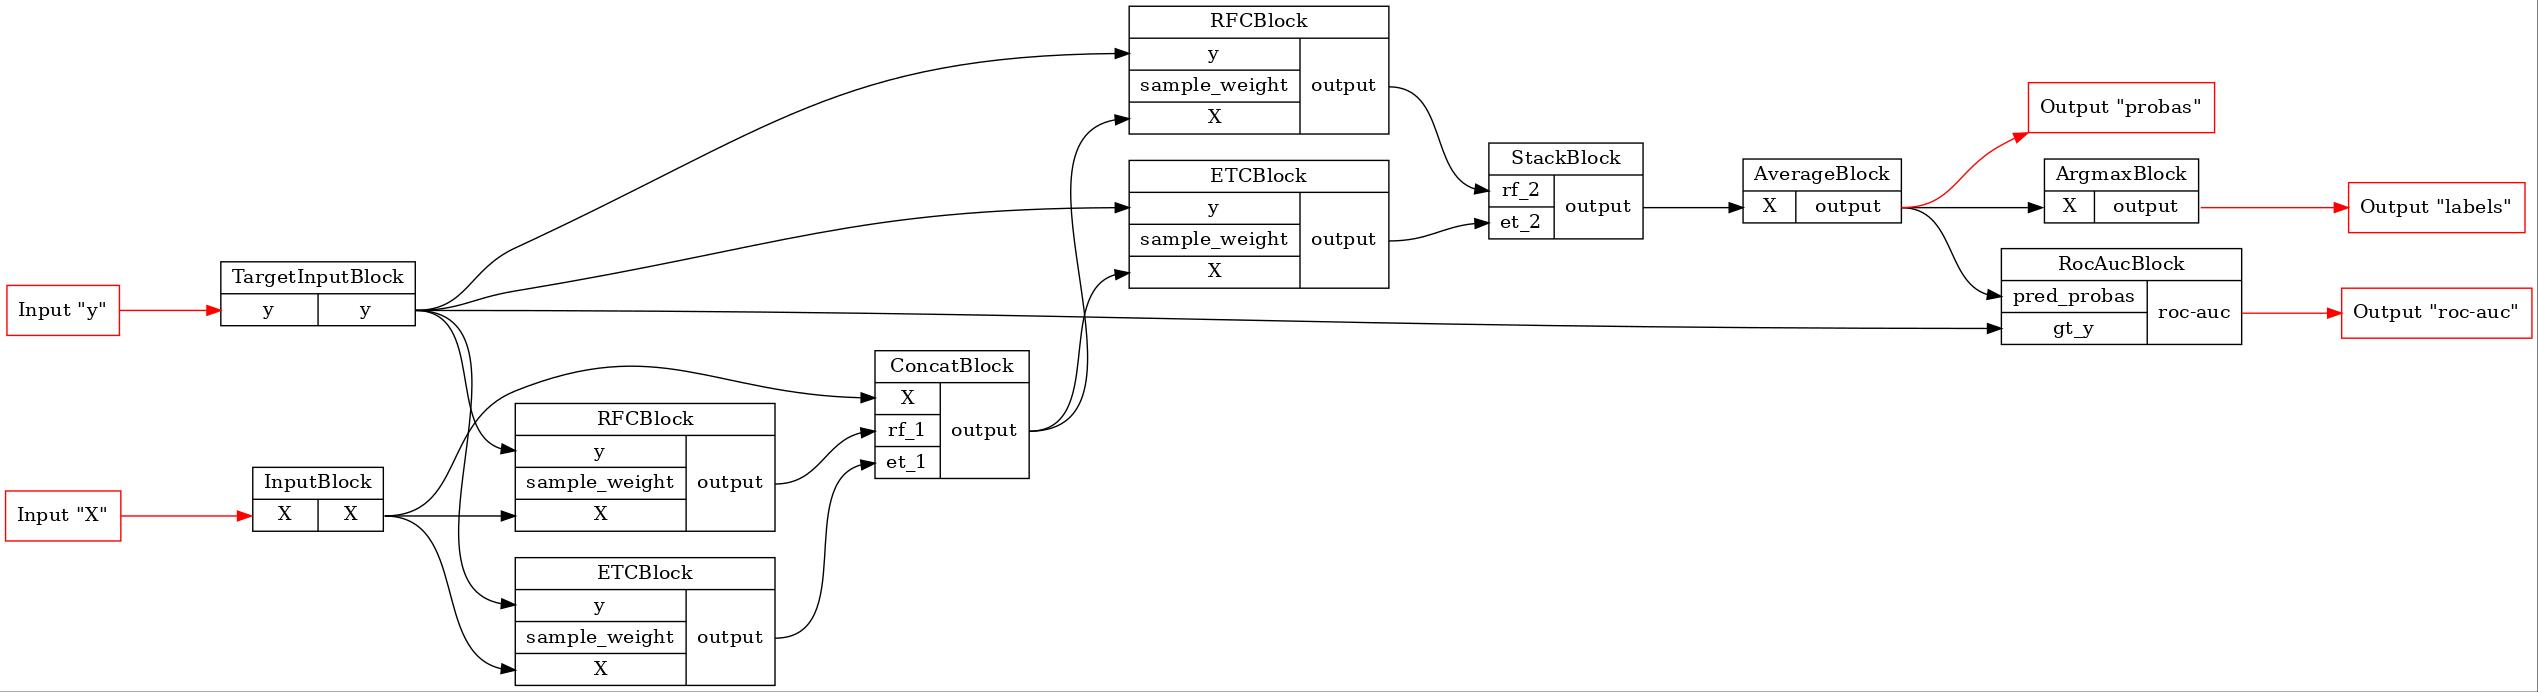

In [2]:
n_estimators = 20
b = FunctionalPipelineBuilder()
X, y = b.Input()(), b.TargetInput()()
rf_1 = b.RFC(n_estimators=n_estimators)(X=X, y=y)
et_1 = b.ETC(n_estimators=n_estimators)(X=X, y=y)
concat_1 = b.Concat(['X', 'rf_1', 'et_1'])(X=X, rf_1=rf_1, et_1=et_1)
rf_2 = b.RFC(n_estimators=n_estimators)(X=concat_1, y=y)
et_2 = b.ETC(n_estimators=n_estimators)(X=concat_1, y=y)
stack = b.Stack(['rf_2', 'et_2'], axis=1)(rf_2=rf_2, et_2=et_2)
average = b.Average(axis=1)(X=stack)
argmax = b.Argmax(axis=1)(X=average)
roc_auc = b.RocAuc()(gt_y=y, pred_probas=average)
pipeline = b.build(
    {'X': X, 'y': y},
    {'labels': argmax, 'probas': average, 'roc-auc': roc_auc}
)
GraphvizPainter(figure_dpi=100).from_pipeline(pipeline).render('pipeline.jpeg')
display(Image('pipeline.jpeg'))

Это простой классифицирующий Глубокий лес с 2 слоями. Предположим, мы хотим нарисовать матрицу ошибок (confusion matrix) для нашей модели. Как мы знаем, sklearn предоставляет эту функциональность. Итак, давайте обернем наш пайплайн в интерфейс sklearn.

По умолчанию `BaseBoskPipelineWrapper` связывает аргументы `X`, `y` и `sample_weigth` метода `fit` с одноименными входами конвейера. Ожидается, что выходные слоты будут называться `pred` и `proba`. Таким образом, нам нужно указать отображение требуемых `pred` и `proba` на наши выходные данные `labels` и `probas`.

In [3]:
sklearn_model = BoskPipelineClassifier(pipeline, outputs_map={'pred': 'labels', 'proba': 'probas'})

Давайте сгенерируем данные, обучим нашу модель и нарисуем матрицу ошибок.

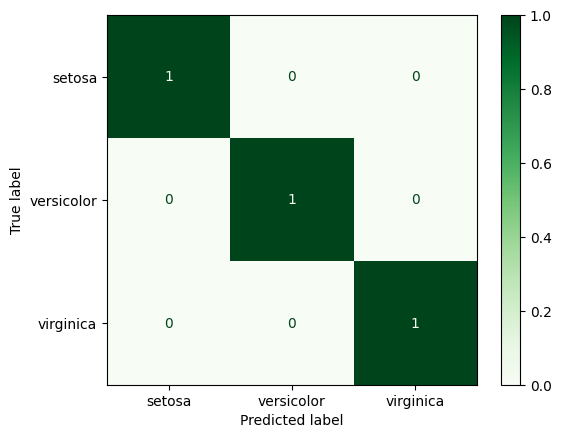

In [4]:
iris = load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
sklearn_model.fit(X_train, y_train)

ConfusionMatrixDisplay.from_estimator(
    sklearn_model,
    X_test,
    y_test,
    display_labels=class_names,
    cmap='Greens',
    normalize='true',
)